In [3]:
from importlib.metadata import version
import re
import tiktoken
import torch

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.2.2
tiktoken version: 0.7.0


In [4]:
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [5]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [6]:
#Tokenizing text
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text) #split some punctuation characters
preprocessed = [item.strip() for item in preprocessed if item.strip()] #remove blanks
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [7]:
#Converting tokens into token IDs
all_words = sorted(set(preprocessed))
vocab = {token:integer for integer,token in enumerate(all_words)}

In [8]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 20:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)


In [9]:
#Building a tokenizer class
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [10]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [11]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [12]:
#Adding special context tokens: "unk" for words not in the vocab and "endoftext" to indicate the end of a text (document)
preprocessed = re.split(r'([,.?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]

all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [13]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1156)
('your', 1157)
('yourself', 1158)
('<|endoftext|>', 1159)
('<|unk|>', 1160)


In [14]:
#Modifying the class to add the special tokens
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [27]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [26]:
tokenizer.encode(text)

[1160,
 5,
 1160,
 362,
 1155,
 642,
 1000,
 10,
 1159,
 57,
 1013,
 981,
 1009,
 738,
 1013,
 1160,
 7]

***BytePair encoding***
- GPT-2 used BytePair encoding (BPE) as its tokenizer
- It allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
- The BPE tokenizer can be found here: https://github.com/openai/tiktoken
- Here we are using the BPE tokenizer from OpenAI's open-source tiktoken library, which implements its core algorithms in Rust to improve computational performance

In [30]:
#Instantiating the tokenizer
tokenizer = tiktoken.get_encoding("gpt2")

In [46]:
text = "Hello, ims do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace."
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[15496, 11, 545, 82, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 34680, 27271, 13]


In [47]:
#Converting back to text
strings=tokenizer.decode(integers)
print(strings)

Hello, ims do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.


Notes:
- the BPE tokenizer that was used to train models such as GPT-2, GPT-3, and ChatGPT has a total vocabulary size of 50,257.in fact,  <|endoftext|> is asssigned the largest token, 50256.
- the BPE tokenizer encodes and decodes unknown words, iwhout using a special <|unk|> token. This is possible because the BPR tokenizer algorithm breaks down words that are not in the predefined vocabulary into smaller subwords unit or even individual characters.


In [49]:
#Example of a totally unknown text
text="Akwirw ier"
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)

[33901, 86, 343, 86, 220, 959]


In [50]:
strings=tokenizer.decode(integers)
print(strings)

Akwirw ier


***Embeddings***

Before creating the embedding, is required to generate the input-target pairs for training an LLM

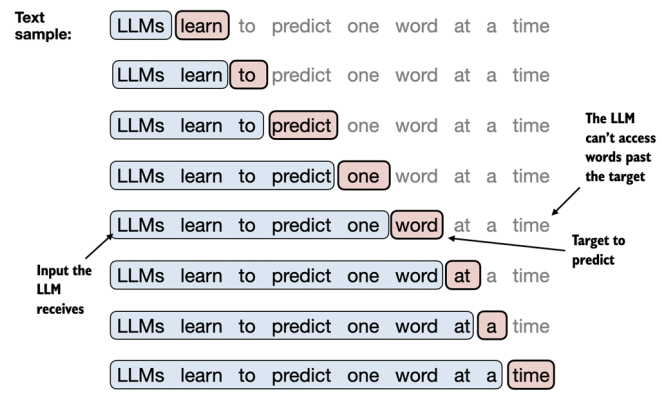

In [79]:
#Loading data and tokenizing
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text))


5145


In [80]:
#Picking a sample for drmonstration purposes
enc_sample = enc_text[50:]

In [81]:
context_size = 4 #number of tookens to be included in the inpult
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]# targey shifted by one
print(f"x: {x}")
print(f"y: {y}")


x: [290, 4920, 2241, 287]
y: [4920, 2241, 287, 257]


In [82]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)


[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [83]:
#Converting back to text
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [ ]:
#Creating a Dataset and Data Loader

In [84]:
#Dataset
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []
        token_ids = tokenizer.encode(txt) #Tokenize the text
        for i in range(0, len(token_ids) - max_length, stride): #Sliding window to chunk the text into overlapping sequences of max_length
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    def __len__(self): #Return number of rows in the dataset
        return len(self.input_ids)
    def __getitem__(self, idx): #Return a single row from the dataset
        return self.input_ids[idx], self.target_ids[idx]


In [85]:
#Data loader
def create_dataloader(txt, batch_size=4, max_length=256, stride=128, shuffle=True):
    tokenizer = tiktoken.get_encoding("gpt2") #Initialize the tokenizer
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) #Create dataset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle) #Create data loader
    return dataloader


In [86]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
dataloader = create_dataloader(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
data_iter = iter(dataloader) # convert dataloader into a Python iterator to fetch the next entry via Python's built-in next() function
first_batch = next(data_iter)
print(first_batch)


[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [87]:
#A stride of 1 moves the input by 1 position
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [102]:
#Other examples with different max length and strides
dataloader = create_dataloader(raw_text, batch_size=1, max_length=2, stride=2, shuffle=False)
data_iter = iter(dataloader) # convert dataloader into a Python iterator to fetch the next entry via Python's built-in next() function
first_batch = next(data_iter)
print(first_batch)
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 40, 367]]), tensor([[ 367, 2885]])]
[tensor([[2885, 1464]]), tensor([[1464, 1807]])]


In [122]:
#Yet other examples with different max length and strides
dataloader = create_dataloader(raw_text, batch_size=1, max_length=8, stride=2, shuffle=False)
data_iter = iter(dataloader) # convert dataloader into a Python iterator to fetch the next entry via Python's built-in next() function
first_batch = next(data_iter)
print(first_batch)
second_batch = next(data_iter)
print(second_batch)

[tensor([[  40,  367, 2885, 1464, 1807, 3619,  402,  271]]), tensor([[  367,  2885,  1464,  1807,  3619,   402,   271, 10899]])]
[tensor([[ 2885,  1464,  1807,  3619,   402,   271, 10899,  2138]]), tensor([[ 1464,  1807,  3619,   402,   271, 10899,  2138,   257]])]


Note: small batch sizes require less memory during training but lead to more noisy model updates

In [125]:
#Stride set to max_length+1 to utilize the full dataset but also to avoid overlap between batches wich could lead to overfitting. 
#If set equal to max_length, the target ID for the last input token in each row becomes the first input token ID in the next row.
dataloader = create_dataloader(raw_text, batch_size=8, max_length=4, stride=5,shuffle=False) 
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)


Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 3619,   402,   271, 10899],
        [  257,  7026, 15632,   438],
        [  257,   922,  5891,  1576],
        [  568,   340,   373,   645],
        [ 5975,   284,   502,   284],
        [  326,    11,   287,   262],
        [  286,   465, 13476,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [  402,   271, 10899,  2138],
        [ 7026, 15632,   438,  2016],
        [  922,  5891,  1576,   438],
        [  340,   373,   645,  1049],
        [  284,   502,   284,  3285],
        [   11,   287,   262,  6001],
        [  465, 13476,    11,   339]])
